# Churn Analysis on a Telecom Dataset

In this notebook, we will be implementing a churn analysis on a sample telecom dataset. Specifically, our goal is to build a machine learning model that can predict whether a customer will churn (leave the service). If we are able to identify the parameters/indicators that contributes to churn rate, the company concerned can prepare and make top-level programs and decisions that can avoid or help these indicators.

We will walk through step-by-step on the data loading, data preprocessing, feature selection, and model training. Our goal is to train some simple ML models, compare their results, and use the best performing one to make predictions on unseen data.

In [ ]:
!pip install scikit-learn pandas numpy matplotlib missingno xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.4 MB/s eta 0:00:00


## Data Loading and Initial Glance

In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

In [10]:
df = pd.read_excel("telecom_churn.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**DataFrame Content Description**

The DataFrame `df` contains information about telecom customers and their churn status. It has 7043 entries and 23 columns with the following data types and descriptions:

*   **customerID**: Object (string) - Unique identifier for each customer.
*   **gender**: Object (string) - The customer's gender (Female or Male).
*   **SeniorCitizen**: int64 (integer) - Indicates if the customer is a senior citizen (1) or not (0).
*   **Partner**: Object (string) - Indicates if the customer has a partner (Yes or No).
*   **Dependents**: Object (string) - Indicates if the customer has dependents (Yes or No).
*   **tenure**: int64 (integer) - Number of months the customer has stayed with the company.
*   **PhoneService**: Object (string) - Indicates if the customer has phone service (Yes or No).
*   **MultipleLines**: Object (string) - Indicates if the customer has multiple lines (Yes, No, or No phone service).
*   **InternetService**: Object (string) - Indicates the customer's internet service type (DSL, Fiber optic, or No).
*   **OnlineSecurity**: Object (string) - Indicates if the customer has online security (Yes, No, or No internet service).
*   **OnlineBackup**: Object (string) - Indicates if the customer has online backup (Yes, No, or No internet service).
*   **DeviceProtection**: Object (string) - Indicates if the customer has device protection (Yes, No, or No internet service).
*   **TechSupport**: Object (string) - Indicates if the customer has tech support (Yes, No, or No internet service).
*   **StreamingTV**: Object (string) - Indicates if the customer is streaming TV (Yes, No, or No internet service).
*   **StreamingMovies**: Object (string) - Indicates if the customer is streaming movies (Yes, No, or No internet service).
*   **Contract**: Object (string) - Indicates the customer's contract type (Month-to-month, One year, or Two year).
*   **PaperlessBilling**: Object (string) - Indicates if the customer has paperless billing (Yes or No).
*   **PaymentMethod**: Object (string) - Indicates the customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), or Credit card (automatic)).
*   **MonthlyCharges**: float64 (float) - The amount charged to the customer monthly.
*   **TotalCharges**: Object (string) - The total amount charged to the customer.
*   **numAdminTickets**: int64 (integer) - Number of administrative tickets opened by the customer.
*   **numTechTickets**: int64 (integer) - Number of technical support tickets opened by the customer.
*   **Churn**: Object (string) - Indicates if the customer churned (Yes or No). This is the target variable for our analysis.

## Data preprocessing

In this part, our goal is to clean and prepare the data for model training, including handling missing values, encoding categorical features, and scaling numerical features.

**Unreasonable dtypes**:
Initial look of the `df` tells that the `TotalCharges` column is in `object/string` format when we expect it to be float. Let's take a closer look at this column



In [11]:
# check unique elements of column
df['TotalCharges'].unique()

array([29.85, 1889.5, 108.15, ..., 346.45, 306.6, 6844.5], dtype=object)

In [12]:
# check for random spaces
# str.match(r'^\s*$') checks for strings that contain only whitespace characters or are empty
# setting na=False converts NaN conversions to False to use it as filter to dataframe
df.loc[df['TotalCharges'].str.match(r'^\s*$', na=False), 'TotalCharges'] = np.nan

# change dtype of column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# check for errors/NaN in conversion
# True values indicates NaN while False indicates actual float values
df['TotalCharges'].isna().value_counts()

,count
TotalCharges,
False,7032
True,11


In [13]:
# final check of dtype
df['TotalCharges'].dtype

dtype('float64')

The `TotalCharges` column now seems to be ready. There are still missing values but we'll impute them altogether later with the other columns having missing values.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [16]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,0,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,5,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,0,0,Yes


Now, we'll look into the numerical and categorical fields of our dataset. We'll collect these fields and separate them since they require different preparation methods.

In [17]:
# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

print(f"Numerical features: {numerical_features} \n")
print(f"Categorical features: {categorical_features}")

Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets'] 

Categorical features: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


Since `customerID` is unique to all rows/customers, we won't be able to use it as features for churn analysis. Additionally, we will use the `Churn` column as our target to predict.

So we'll remove both of these columns in our list of features.

In [19]:
# Remove 'customerID' and 'Churn' from features as they are not used for training directly
if 'customerID' in numerical_features:
    numerical_features.remove('customerID')
if 'customerID' in categorical_features:
    categorical_features.remove('customerID')
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')
if 'Churn' in numerical_features:
    numerical_features.remove('Churn')

print(f"Numerical features: {numerical_features} \n")
print(f"Categorical features: {categorical_features}")

Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets'] 

Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


### Preprocessing Explainer

We'll be implementing different preprocessing techniques for the numerical and categorical features. For the numerical, our goal is to impute the missing values with the value of our choice and scale them for better training and predicting.

In [22]:
df_explainer = df.copy(deep=True)

# imputing numerical features
imputer = SimpleImputer(strategy='mean')
df_explainer[numerical_features] = imputer.fit_transform(df[numerical_features])

# scaling numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df[numerical_features]

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
0,-0.439916,-1.277445,-1.160323,-0.994194,-0.404396,-0.335645
1,-0.439916,0.066327,-0.259629,-0.173740,-0.404396,-0.335645
2,-0.439916,-1.236724,-0.362660,-0.959649,-0.404396,-0.335645
3,-0.439916,0.514251,-0.746535,-0.195248,-0.404396,2.064301
4,-0.439916,-1.236724,0.197365,-0.940457,-0.404396,-0.335645
...,...,...,...,...,...,...
7038,-0.439916,-0.340876,0.665992,-0.129180,-0.404396,-0.335645
7039,-0.439916,1.613701,1.277533,2.241056,-0.404396,3.664265
7040,-0.439916,-0.870241,-1.168632,-0.854514,-0.404396,-0.335645
7041,2.273159,-1.155283,0.320338,-0.872095,-0.404396,-0.335645


Meanwhile the categorical features are to be converted into numerical in order for the model to learn from them. For this, we use **One Hot Encoding**. An example on how this model works is given below.

In [25]:
# Example DataFrame with a categorical column
data = {'Color': ['Red', 'Blue', 'Green', 'Blue', 'Red', 'Yellow']}
df_example = pd.DataFrame(data)
df_example

,Color
0,Red
1,Blue
2,Green
3,Blue
4,Red
5,Yellow


In [26]:
# initialize encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# transform example df
df_encoded = encoder.fit_transform(df_example)

# get feature names and set as columns
feature_names = encoder.get_feature_names_out(['Color'])
encoded_df = pd.DataFrame(df_encoded.toarray(), columns=feature_names)

encoded_df

,Color_Blue,Color_Green,Color_Red,Color_Yellow
0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0


### Preprocessing Combined

Doing all of the transformations above is a bit tricky if we'll have to check whether a column is numerical or not one at a time. Instead, what we'll do is to combine these processes into a pipeline that can work for any similar dataset that we have.

In [28]:
# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with the median
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

From the pipeline for each of the numerical and categorical features, we then use the `ColumnTransformer` method to combine the transformations into one command/call. A visual example of this process is given below.

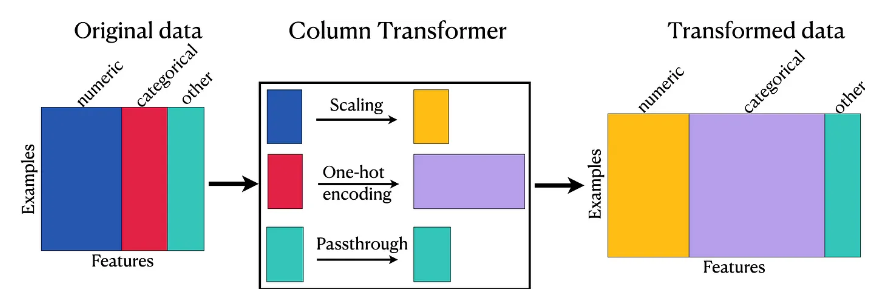

In [29]:
# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])  # use remainder='passthrough' for other features if no transformation required

# Apply the preprocessing
df_preprocessed = preprocessor.fit_transform(df)

In [31]:
# Convert the preprocessed data back to a DataFrame for inspection
# Get feature names after one-hot encoding
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(onehot_feature_names)

all_feature_names

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'numAdminTickets',
 'numTechTickets',
 'gender_Female',
 'gender_Male',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'Paperless

In [34]:
# update column headers of dataframe
df_preprocessed = pd.DataFrame(df_preprocessed, columns=all_feature_names)

# 4. Display the first few rows and information of the preprocessed DataFrame
df_preprocessed.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,gender_Female,gender_Male,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.160323,-0.994971,-0.404396,-0.335645,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.439916,0.066327,-0.259629,-0.173876,-0.404396,-0.335645,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.439916,-1.236724,-0.362660,-0.960399,-0.404396,-0.335645,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.439916,0.514251,-0.746535,-0.195400,-0.404396,2.064301,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.439916,-1.236724,0.197365,-0.941193,-0.404396,-0.335645,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Feature selection

Now that we prepared/preprocessed our features, it's important to note that not all of these features are relevant contributors of churn rate. Hence, we'll need to select the most relevant features for predicting churn to improve model performance and interpretability.

Our plan here is to convert the target variable (`Churn` column) to numerical format, calculate its correlation with each feature, and select features based on a threshold.


In [35]:
# separate features (X) and prepared target (y)
X = df_preprocessed
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convert 'Yes' to 1 and 'No' to 0

In [37]:
# combine features and targets to calculate correlation
X_with_y = X.copy(deep=True)
X_with_y['Churn'] = y

# calculate correlations of features vs Churn
correlations = X_with_y.corr()['Churn'].sort_values(ascending=False)

In [41]:
correlations.head(6), correlations.tail(5)

(Churn                          1.000000
 Contract_Month-to-month        0.405103
 numTechTickets                 0.357283
 OnlineSecurity_No              0.342637
 TechSupport_No                 0.337281
 InternetService_Fiber optic    0.308020
 Name: Churn, dtype: float64,
 OnlineSecurity_No internet service    -0.227890
 StreamingMovies_No internet service   -0.227890
 StreamingTV_No internet service       -0.227890
 Contract_Two year                     -0.302253
 tenure                                -0.352229
 Name: Churn, dtype: float64)

In [59]:
# Select features based on a correlation threshold (e.g., absolute correlation > 0.10)
# You can adjust this threshold based on your analysis
correlation_threshold = 0.10
relevant_features = correlations[abs(correlations) > correlation_threshold].index.tolist()

# Remove the target variable from the list of relevant features if it's included
if 'Churn' in relevant_features:
    relevant_features.remove('Churn')

In [60]:
# Update X to include only the selected features
X_selected = X[relevant_features]

# Display the first few rows of the feature selected DataFrame
X_selected.head()

,Contract_Month-to-month,numTechTickets,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_No,DeviceProtection_No,MonthlyCharges,PaperlessBilling_Yes,...,TotalCharges,TechSupport_No internet service,InternetService_No,DeviceProtection_No internet service,OnlineBackup_No internet service,OnlineSecurity_No internet service,StreamingMovies_No internet service,StreamingTV_No internet service,Contract_Two year,tenure
0,1.0,-0.335645,1.0,1.0,0.0,1.0,0.0,1.0,-1.160323,1.0,...,-0.994971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.277445
1,0.0,-0.335645,0.0,1.0,0.0,0.0,1.0,0.0,-0.259629,0.0,...,-0.173876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066327
2,1.0,-0.335645,0.0,1.0,0.0,0.0,0.0,1.0,-0.362660,1.0,...,-0.960399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.236724
3,0.0,2.064301,0.0,0.0,0.0,0.0,1.0,0.0,-0.746535,0.0,...,-0.195400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514251
4,1.0,-0.335645,1.0,1.0,1.0,1.0,1.0,1.0,0.197365,1.0,...,-0.941193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.236724


## Classification: Where Machines Learn

Now, it's time for our models to learn. We'll try 3 of the most common machine learning algorithms that are used, evaluate them, and compare their results.

In [61]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Logistic Regression model
model_LR = LogisticRegression() # Using liblinear solver as it's good for small datasets
model_SVM = SVC(kernel='rbf', probability=True) # Using probability=True for ROC AUC calculation
model_RF = RandomForestClassifier()

# Train the models
model_LR.fit(X_train, y_train)
model_SVM.fit(X_train, y_train)
model_RF.fit(X_train, y_train)

# Predict on the test set
predictions = {'lr': [], 'svm': [], 'rf': [], 'true': y_test}
predictions['lr'] = model_LR.predict(X_test)
predictions['svm'] = model_SVM.predict(X_test)
predictions['rf'] = model_RF.predict(X_test)

# Evaluate the model (we will do a more detailed evaluation in the next step)
print(f"Accuracy of the Logistic Regression model: {accuracy_score(predictions['lr'], predictions['true']):0.4f}")
print(f"Accuracy of the Support Vector Machines model: {accuracy_score(predictions['svm'], predictions['true']):0.4f}")
print(f"Accuracy of the Random Forest model: {accuracy_score(predictions['rf'], predictions['true']):0.4f}")

Accuracy of the Logistic Regression model: 0.8559
Accuracy of the Support Vector Machines model: 0.8552
Accuracy of the Random Forest model: 0.8474


Results show that the performance of the models, in terms of accuracy, ranges between 85%-86%. In practice, this is a good performance, but we would always aim to make it higher. There are different ways to do this: hyperparameter tuning, feature engineering, dimensionality reduction, training a better yet more complex model, or directly improving the data.

In this notebook, we'll implement hyperparameter tuning on the `LogisticRegression` model, the best one we obtained earlier. A guide of which is given below.

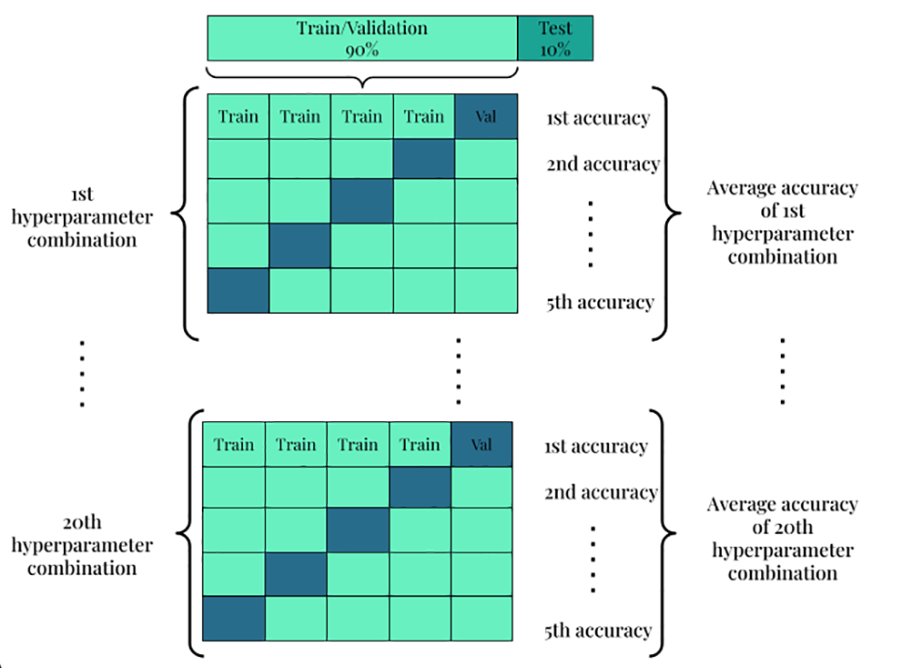

In [63]:
# Split the data into training and testing sets (using X_selected)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# --- Hyperparameter Tuning for Logistic Regression ---
print("Tuning hyperparameters for Logistic Regression...")
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # liblinear supports both l1 and l2 penalties
}

# apply grid search cross-validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")

# Evaluate the tuned Logistic Regression model on the test set
tuned_model = LogisticRegression(**grid_search.best_params_).fit(X_train, y_train)
y_pred_tuned = tuned_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy of tuned Logistic Regression model on test set: {accuracy_tuned:.4f}")

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy of tuned Logistic Regression model on test set: 0.8566


Observe that the accuracy of the LR model improved from 85.59% to 85.66%. Not so much of an improvement but changes are observed. This means that other techniques can be done to improve the results.

For a detailed view of the performance of the LR model, we can use the `classification_report` function of `sklearn`.

In [64]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1035
           1       0.76      0.68      0.72       374

    accuracy                           0.86      1409
   macro avg       0.82      0.80      0.81      1409
weighted avg       0.85      0.86      0.85      1409



## Clustering Customers

In this part, we'd like to explore the clustering/groupings that we can observce from our dataset. Additionally, we would like to explore different number of clusters created by KMeans and choose the best one in terms of silhouette scores. Finally, our goal is to explore the similarities of customers within the same clusters and their differences from other clusters.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

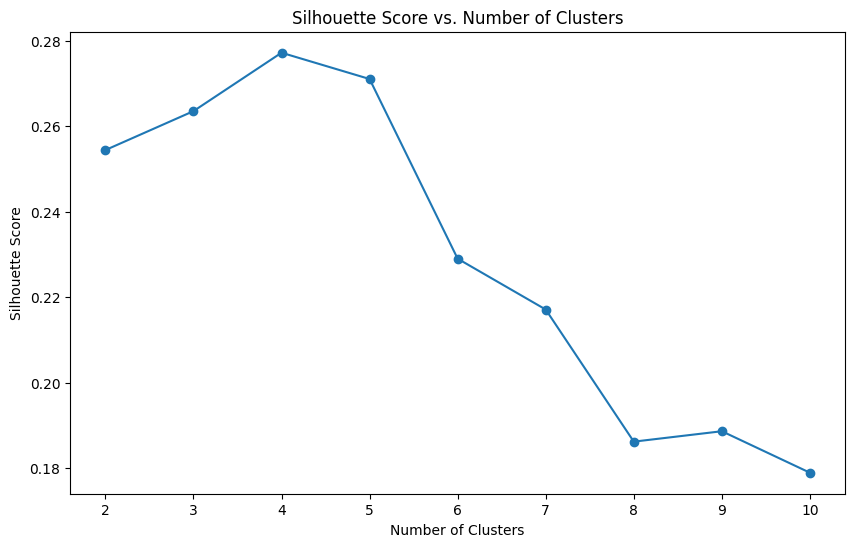

In [67]:
# Determine the optimal number of clusters using the Elbow method and Silhouette score
# We'll check for a range of possible cluster numbers
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Initialize KMeans with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    # Fit KMeans and calculate the silhouette score
    cluster_labels = kmeans.fit_predict(X_selected)
    silhouette_avg = silhouette_score(X_selected, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores for different number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(False)
plt.show()

In [76]:
# Find the number of clusters with the highest silhouette score
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters based on Silhouette Score is: {optimal_n_clusters}")

# Perform KMeans clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans_optimal.fit_predict(X_selected)

# Display the first few rows with the assigned cluster
df.head()

The optimal number of clusters based on Silhouette Score is: 4


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn,Cluster
0,7590-VHVEG,Female,-0.439916,Yes,No,-1.277445,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,-1.160323,-0.994194,-0.404396,-0.335645,No,0
1,5575-GNVDE,Male,-0.439916,No,No,0.066327,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,-0.259629,-0.173740,-0.404396,-0.335645,No,0
2,3668-QPYBK,Male,-0.439916,No,No,-1.236724,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,-0.362660,-0.959649,-0.404396,-0.335645,Yes,0
3,7795-CFOCW,Male,-0.439916,No,No,0.514251,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),-0.746535,-0.195248,-0.404396,2.064301,No,3
4,9237-HQITU,Female,-0.439916,No,No,-1.236724,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,0.197365,-0.940457,-0.404396,-0.335645,Yes,0


### Cluster Analysis

Now that we have assigned each customer to a cluster, let's analyze the characteristics of each cluster to understand the groupings. We can start by looking at the churn rate and the distribution of key features within each cluster.

In [85]:
# Analyze churn rate per cluster
churn_by_cluster = df.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()
churn_by_cluster

# Analyze categorical features by cluster (optional - can be done visually or by value counts)
# For example, to see the distribution of 'Contract' within each cluster:

Churn,No,Yes
Cluster,,
0,0.573128,0.426872
1,0.986280,0.013720
2,0.925658,0.074342
3,0.222437,0.777563


In [88]:
# Analyze numerical features by cluster
numerical_summary_by_cluster = df.groupby('Cluster')[numerical_features].mean()
display(numerical_summary_by_cluster)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
Cluster,,,,,,
0,0.099908,-0.728917,0.125753,-0.569043,-0.006632,-0.223272
1,0.008206,1.063858,0.711217,1.223899,0.018112,-0.290897
2,-0.347101,-0.080507,-1.452092,-0.715514,0.002658,-0.251963
3,0.389224,0.723445,0.905622,1.027947,-0.034297,3.150543


In [94]:
# Analyze categorical distribution by cluster
category = 'Contract'
category_by_cluster = df.groupby('Cluster')[category].value_counts(normalize=True).unstack()
category_by_cluster

Contract,Month-to-month,One year,Two year
Cluster,,,
0,0.883960,0.096753,0.019286
1,0.169921,0.349340,0.480739
2,0.344737,0.239474,0.415789
3,0.539652,0.282398,0.177950
